# How to request and plot histograms
For every state and extraction time point the MC engine computes _mean_, _stddev_ and _skewness_ values of

In [1]:
from init import *

## The model
### Two correlated Brownian motion processes

In this model we will generate two correlated normally distributed random variables and then define two Brownan motion processes:

\begin{eqnarray}
W_1 &\sim& N(0,1)
\\
W_2 &\sim& N(0,1)
\\
\text{d}S_1 &=& \mu_1\text{d}t + \sigma_1 \text{d}W_1
\\
\text{d}S_2 &=& \mu_2\text{d}t + \sigma_2 \text{d}W_2
\end{eqnarray}

with 

\begin{eqnarray}
[\text{d}W_1,\text{d}W_2] = \rho \text{d}t
\end{eqnarray}


In [2]:
def model_correlated_bm ():
    model = sdk.Model()
    model.TimeStart = 0
    model.TimeSteps = 1000
    model.NumPaths = 10000
    model.LogLevel = 'info'
    model.LogSize = 100*1024
    
    correlation = -0.95

    r = model.Add(sdk.Updater(
        name    = "RandomNormal",
        args    = [correlation],
        nstates = 2,
        title   = 'W1,W2'
    ))

    model.bm1 = model.Add(sdk.Updater(
        name    = "BrownianMotion",
        refs    = [r.GetStateNumber()],
        args    = [0.2,0.7],
        start   = [0],
        title   = 'BM(W1)'
    ))

    model.bm2 = model.Add(sdk.Updater(
        name    = "BrownianMotion",
        refs    = [r.GetStateNumber()+1],
        args    = [-0.3,0.5],
        start   = [1],
        title   = 'BM(W2)'
    ))

    return model

## Adding extraction points
Our BM processes will start at $t=0$, and lets say we want to extract results three time points: $1,2,5$.
### ... without histogram request


In [3]:
model = model_correlated_bm()
for t in [1]:
    model.evaluations.append(sdk.EvaluationPoint(t))
results = sdk.run (model, server)
results.df()

,name,title,state,point,time,step,npaths,mean,mean_error,stddev,skewness
0,RandomNormal,"W1,W2",0,0,1.0,999,10000,-0.013873,0.009972,0.997214,-0.020002
1,RandomNormal,,1,0,1.0,999,10000,0.011753,0.010004,1.000415,0.026058
2,BrownianMotion,BM(W1),2,0,1.0,999,10000,0.197885,0.006949,0.694851,0.002096
3,BrownianMotion,BM(W2),3,0,1.0,999,10000,0.699981,0.004988,0.498819,0.006868


There are no histograms in the _results_ object:

In [4]:
len(results.histograms)

0

### ... adding 1D histogram
We need to attach a histogram request to evaluation points. A histogram defintion requires one (for 1d-histogram)  or two (2d-histogram) axis definitions. To define an axis we need to know:

- a state number from which data will be taken during histogram fill process
- number of bins to be used for filling
- [optional] (min,max) axis range. 

If $(min,max)$ is not provided, or the range is badly defined (the values must be finite and $min<max$), the MC engine will determine the range itself, using _mean,stddev_ and _skewness_ parameters of a state distribution.

In [5]:
model = model_correlated_bm()
for t in [1,2,5]:
    model.evaluations.append(
        sdk.EvaluationPoint(t)
            .Add(sdk.Histogram(
                # for W1 histogram we request the engine to compute the range
                AxisX = sdk.HistogramAxis(state=model.bm1.GetStateNumber(),nbins=100,title='x-axis'),
            ))
            .Add(sdk.Histogram(
                # for W2 histogram we provide the range (min,max)
                AxisX = sdk.HistogramAxis(state=model.bm2.GetStateNumber(),nbins=100,min=-5,max=5),
            ))
    )
results = sdk.run (model, server)
results.df()

,name,title,state,point,time,step,npaths,mean,mean_error,stddev,skewness
0,RandomNormal,"W1,W2",0,0,1.0,199,10000,-0.013216,0.010028,1.002805,-0.003675
1,RandomNormal,,1,0,1.0,199,10000,0.011013,0.010035,1.003519,-0.003203
2,BrownianMotion,BM(W1),2,0,1.0,199,10000,0.200464,0.007018,0.701828,-0.008352
3,BrownianMotion,BM(W2),3,0,1.0,199,10000,0.699883,0.004998,0.499838,-0.001582
4,RandomNormal,"W1,W2",0,1,2.0,399,10000,0.006527,0.010045,1.004537,-0.010807
5,RandomNormal,,1,1,2.0,399,10000,-0.004506,0.010041,1.004081,0.046069
6,BrownianMotion,BM(W1),2,1,2.0,399,10000,0.403117,0.009934,0.993417,0.003012
7,BrownianMotion,BM(W2),3,1,2.0,399,10000,0.394906,0.007103,0.710322,0.023395
8,RandomNormal,"W1,W2",0,2,5.0,999,10000,-0.017357,0.010024,1.002439,-0.005054
9,RandomNormal,,1,2,5.0,999,10000,0.013140,0.010047,1.004747,0.023159


We requested two histograms for each of the three extraction points:

In [6]:
len(results.histograms)

6

### ... adding 2D histogram

To define a 2D histogram we need to pass one more axis definition:

In [7]:
model = model_correlated_bm()
for t in [1,2,5]:
    model.evaluations.append(
        sdk.EvaluationPoint(t)
            .Add(sdk.Histogram(
                # for W1 histogram we request the engine to compute the range
                AxisX = sdk.HistogramAxis(state=model.bm1.GetStateNumber(),nbins=100,title='W1'),
                Title='Random variable distribution'
            ))
            .Add(sdk.Histogram(
                # for W2 histogram we provide the range (min,max)
                AxisX = sdk.HistogramAxis(state=model.bm2.GetStateNumber(),nbins=100,min=-5,max=5,title='W2'),
                Title='Random variable distribution'
            ))
            .Add(sdk.Histogram(
                AxisX = sdk.HistogramAxis(model.bm1.GetStateNumber(),nbins=100,title='W1'),
                AxisY = sdk.HistogramAxis(model.bm2.GetStateNumber(),nbins=100,min=-5,max=5,title='W2'),
                Title='Random variable distribution'
            ))
    )
results = sdk.run (model, server)
results.df()

,name,title,state,point,time,step,npaths,mean,mean_error,stddev,skewness
0,RandomNormal,"W1,W2",0,0,1.0,199,10000,-0.013216,0.010028,1.002805,-0.003675
1,RandomNormal,,1,0,1.0,199,10000,0.011013,0.010035,1.003519,-0.003203
2,BrownianMotion,BM(W1),2,0,1.0,199,10000,0.200464,0.007018,0.701828,-0.008352
3,BrownianMotion,BM(W2),3,0,1.0,199,10000,0.699883,0.004998,0.499838,-0.001582
4,RandomNormal,"W1,W2",0,1,2.0,399,10000,0.006527,0.010045,1.004537,-0.010807
5,RandomNormal,,1,1,2.0,399,10000,-0.004506,0.010041,1.004081,0.046069
6,BrownianMotion,BM(W1),2,1,2.0,399,10000,0.403117,0.009934,0.993417,0.003012
7,BrownianMotion,BM(W2),3,1,2.0,399,10000,0.394906,0.007103,0.710322,0.023395
8,RandomNormal,"W1,W2",0,2,5.0,999,10000,-0.017357,0.010024,1.002439,-0.005054
9,RandomNormal,,1,2,5.0,999,10000,0.013140,0.010047,1.004747,0.023159


### Notes
- You can add histogram filling request only to some of evaluation points.
- For the same evaluation point and the same state (or states for 2dhist), several histogram request can be made (with different binning and/or axis range).
- Histograms objects can be big, be carefull with bin sizes and the number of requested histograms.

## Plotting histograms
There is a helper function *plot()* to do the job.

## Histograms at extraction point 0

In [8]:
show_histograms(results)

,Title,TimeStep,X title,X bins,X min,X max,Y title,Y bins,Y min,Y max
0,Random variable distribution,199,W1,100,-1.905022,2.305949,NaN,NaN,NaN,NaN
1,Random variable distribution,199,W2,100,-5.000000,5.000000,NaN,NaN,NaN,NaN
2,Random variable distribution,199,W1,100,-1.905022,2.305949,W2,100.0,-5.0,5.0
3,Random variable distribution,399,W1,100,-2.577135,3.383369,NaN,NaN,NaN,NaN
4,Random variable distribution,399,W2,100,-5.000000,5.000000,NaN,NaN,NaN,NaN
5,Random variable distribution,399,W1,100,-2.577135,3.383369,W2,100.0,-5.0,5.0
6,Random variable distribution,999,W1,100,-3.679978,5.670527,NaN,NaN,NaN,NaN
7,Random variable distribution,999,W2,100,-5.000000,5.000000,NaN,NaN,NaN,NaN
8,Random variable distribution,999,W1,100,-3.679978,5.670527,W2,100.0,-5.0,5.0


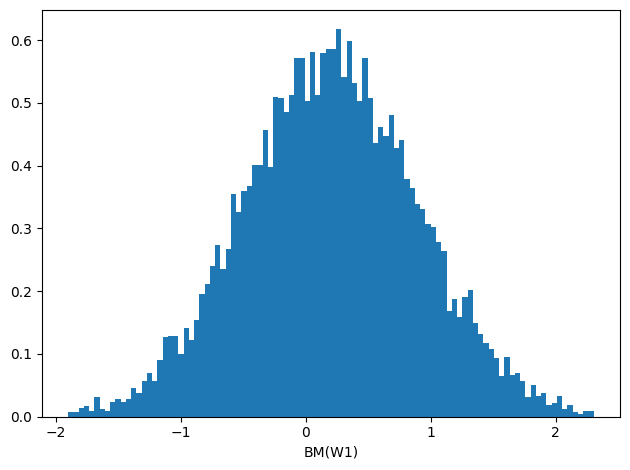

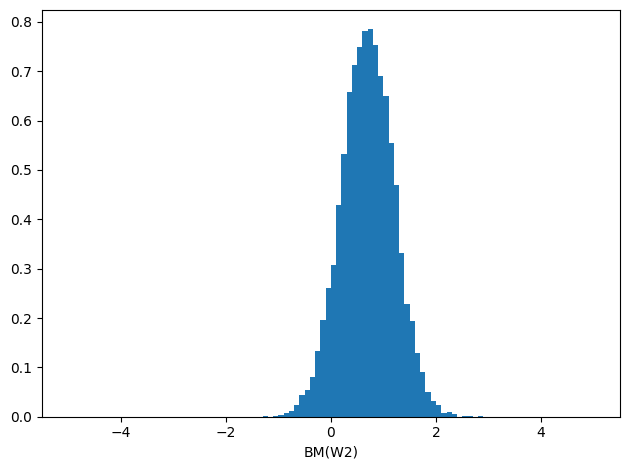

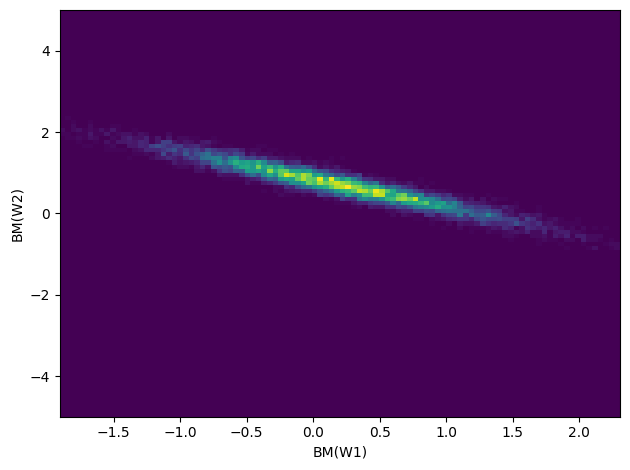

In [9]:
point = results.time_steps[0]
plot(results,point,model.bm1.GetStateNumber())
plot(results,point,model.bm2.GetStateNumber())
plot(results,point,model.bm1.GetStateNumber(),model.bm2.GetStateNumber())

## Histograms at extraction point 1

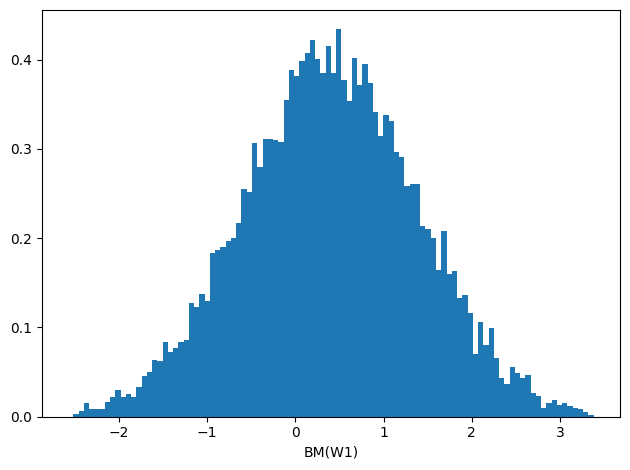

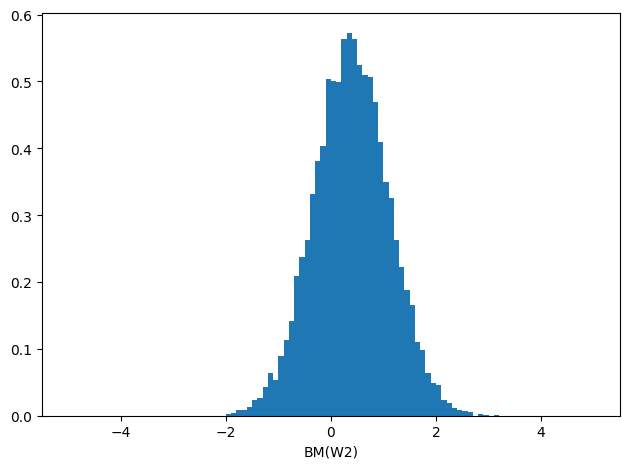

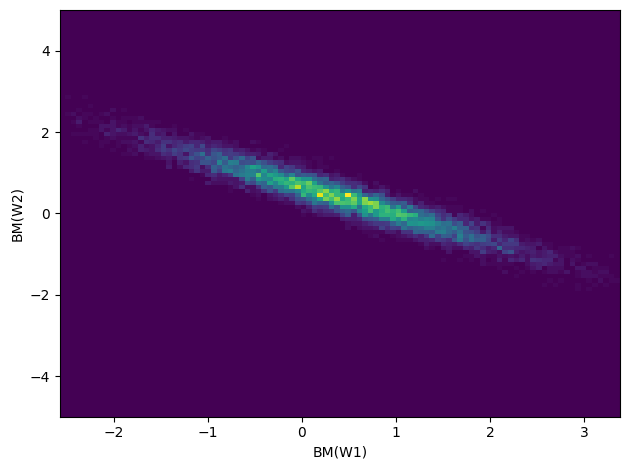

In [10]:
if len(results.time_steps)>1:
    point = results.time_steps[1]
    plot(results,point,model.bm1.GetStateNumber())
    plot(results,point,model.bm2.GetStateNumber())
    plot(results,point,model.bm1.GetStateNumber(),model.bm2.GetStateNumber())

## Histograms at extraction point 2

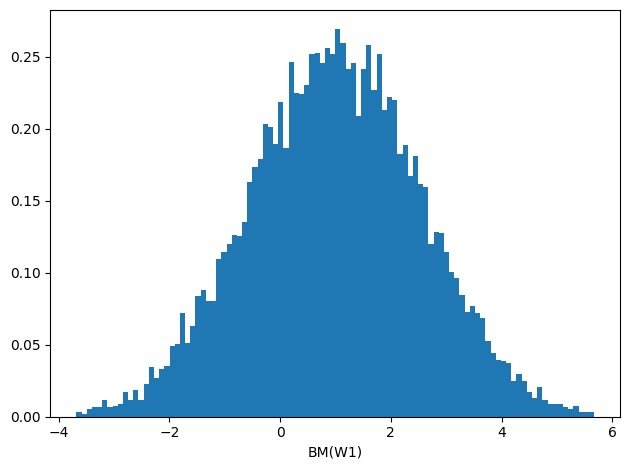

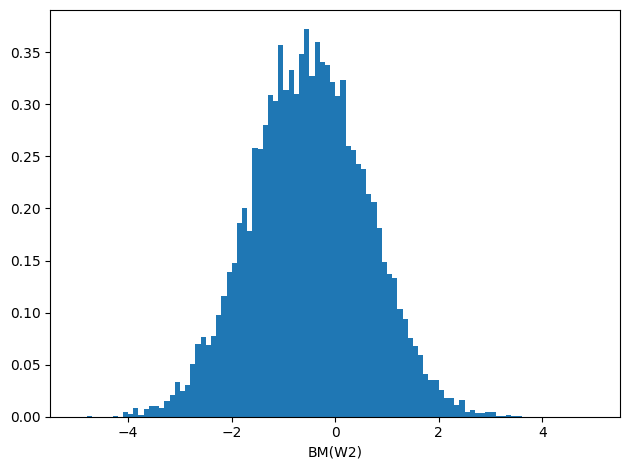

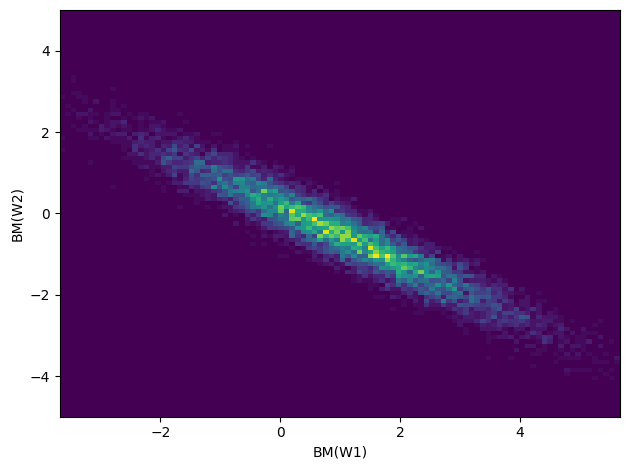

In [11]:
if len(results.time_steps)>2:
    point = results.time_steps[2]
    plot(results,point,model.bm1.GetStateNumber())
    plot(results,point,model.bm2.GetStateNumber())
    plot(results,point,model.bm1.GetStateNumber(),model.bm2.GetStateNumber())

In [12]:
for log in results.logs:
    print(log.strip())

[2025-03-02 21:17:15.466] [Model] [info] There are 3 histograms at evaluation point 0
[2025-03-02 21:17:15.466] [Model] [info] There are 3 histograms at evaluation point 1
[2025-03-02 21:17:15.466] [Model] [info] There are 3 histograms at evaluation point 2
[2025-03-02 21:17:15.466] [Model] [info] updaters_histogram_memory=0 evaluation_points_histogram_memory=124308 histogram_memory=124308
[2025-03-02 21:17:15.466] [Model] [info] The model has 3 updaters to manage 4 states.
[2025-03-02 21:17:15.466] [Model] [info] updaters_memory_total=0
[2025-03-02 21:17:15.466] [Model] [info] logs_buffer_size_bytes=1000000
[2025-03-02 21:17:15.466] [Model] [info] histograms_buffer_size_bytes=0
[2025-03-02 21:17:15.513] [Model] [info] Histograms container: body_size=124308 body_max_size=124308
